In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set_style('darkgrid')
df = pd.read_csv('market_data.csv', index_col='Date')

In [4]:
df.head()

,SP 500 Change %,UST 2yr Change %,UST 10yr Change %,Euro Bond Vol.,Euro Bond Change %,Gold Vol.,Gold Change %,Crude Oil Vol.,Crude Oil Change %,Dollar Index Vol.,Dollar Index Change %,VIX Change %,UST 10yr Direction
Date,,,,,,,,,,,,,
2008-12-29,-0.0039,-0.1356,-0.0154,132.15,0.0034,0.13,0.0048,150.60,0.0613,3.80,-0.0020,0.0120,0
2008-12-30,0.0244,-0.0753,-0.0228,163.39,-0.0041,0.14,-0.0061,137.26,-0.0247,1.70,0.0031,-0.0517,0
2009-01-02,0.0316,0.0768,0.0635,212.35,0.0035,0.05,-0.0054,184.68,0.0390,2.88,0.0080,-0.0203,1
2009-01-05,-0.0047,-0.0617,0.0525,428.41,-0.0050,0.04,-0.0246,258.76,0.0533,4.45,0.0093,-0.0028,1
2009-01-06,0.0078,0.0039,-0.0141,567.17,-0.0098,0.11,0.0096,331.31,-0.0047,5.95,0.0017,-0.0133,0


In [5]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

y = np.asarray(df['UST 10yr Direction'])
y = y[1:]
X = np.asarray(df.drop('UST 10yr Direction', axis=1))
X = X[:-1]
cv_splits = 5
tscv = TimeSeriesSplit(n_splits=cv_splits)

cv_sets = {}
i = 0
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv_sets['x_' + str(i)] = X_train, X_test
    cv_sets['y_' + str(i)] = y_train, y_test
    i += 1

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

model_scores = pd.DataFrame(index=['Accuracy', 'F1', 'Precision', 'Recall'])
model_scores.loc['Accuracy', 'Base Case'] = accuracy_score(y, [0] * len(y))
model_scores.loc['F1', 'Base Case'] = f1_score(y, [0] * len(y))
model_scores.loc['Precision', 'Base Case'] = precision_score(y, [0] * len(y))
model_scores.loc['Recall', 'Base Case'] = recall_score(y, [0] * len(y))
model_scores.loc['ROC-AUC', 'Base Case'] = roc_auc_score(y, [0] * len(y))
base_accuracy = model_scores.loc['Accuracy', 'Base Case']
base_roc_auc = model_scores.loc['ROC-AUC', 'Base Case']
model_scores

,Base Case
Accuracy,0.527203
F1,0.000000
Precision,0.000000
Recall,0.000000
ROC-AUC,0.500000


### ML Functions

In [7]:
def train_test_model(cv_number, model_type, param, test=1, cm=False):
    X = cv_sets['x_' + str(cv_number)][0]
    y = cv_sets['y_' + str(cv_number)][0]

    if model_type == 'decision tree':
        tree_clf = DecisionTreeClassifier(max_depth=param, criterion='entropy', random_state=42)
        tree_clf.fit(X, y)
        model_predictions = tree_clf.predict(cv_sets['x_' + str(cv_number)][test])
    elif model_type == 'boosting':
        boost_clf = GradientBoostingClassifier(max_depth=2, n_estimators=param, random_state=42)
        boost_clf.fit(X, y)
        model_predictions = boost_clf.predict(cv_sets['x_' + str(cv_number)][test])
    elif model_type == 'linear svm':
        svm_clf = LinearSVC(loss='hinge', C=param, random_state=42)
        svm_clf.fit(X, y)
        model_predictions = svm_clf.predict(cv_sets['x_' + str(cv_number)][test])
    elif model_type == 'kernel svm':
        svm_clf = SVC(kernel='poly', degree=param, random_state=42)
        svm_clf.fit(X, y)
        model_predictions = svm_clf.predict(cv_sets['x_' + str(cv_number)][test])
    else:
        knn_clf = KNeighborsClassifier(n_neighbors=param)
        knn_clf.fit(X, y)
        model_predictions = knn_clf.predict(cv_sets['x_' + str(cv_number)][test])
    
    scores = accuracy_score(cv_sets['y_' + str(cv_number)][test], model_predictions), f1_score(cv_sets['y_' + str(cv_number)][test], model_predictions), precision_score(cv_sets['y_' + str(cv_number)][test], model_predictions), recall_score(cv_sets['y_' + str(cv_number)][test], model_predictions), roc_auc_score(cv_sets['y_' + str(cv_number)][test], model_predictions)
    if cm:
        cm_df = pd.crosstab(cv_sets['y_4'][1], model_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
        roc = roc_curve(cv_sets['y_4'][1], model_predictions)
        return scores, cm_df, roc
    return scores

def calc_accuracy(rng, model_type, set='test'):
    summary_dict = {}
    for n in range(cv_splits-1):
        summary_dict[n] = {}
        summary_dict[n]['param'] = []
        summary_dict[n]['accuracy_'+str(n)] = []
        summary_dict[n]['precision_'+str(n)] = []
        summary_dict[n]['recall_'+str(n)] = []
        summary_dict[n]['f1_'+str(n)] = []
        summary_dict[n]['auc_'+str(n)] = []
        for i in rng: 
            summary_dict[n]['param'].append(i)
            if set == 'test':
                scores = train_test_model(n, model_type, i)
            else:
                scores = train_test_model(n, model_type, i, 0)
            summary_dict[n]['accuracy_'+str(n)].append(scores[0])
            summary_dict[n]['precision_'+str(n)].append(scores[1])
            summary_dict[n]['recall_'+str(n)].append(scores[2])
            summary_dict[n]['f1_'+str(n)].append(scores[3])
            summary_dict[n]['auc_'+str(n)].append(scores[4])
        summary_dict[n] = pd.DataFrame(summary_dict[n])
        
    df_summary = summary_dict[0]
    for i in range(1,cv_splits-1):
        df_summary = pd.merge(df_summary, summary_dict[i])
        
    acc_cols, prec_cols, rec_cols, f1_cols, auc_cols = df_splitter(df_summary)
    
    if set == 'test':
        df_summary['Validation Accuracy'] = df_summary[acc_cols].mean(axis=1)
        df_summary['Validation Precision'] = df_summary[prec_cols].mean(axis=1)
        df_summary['Validation Recall'] = df_summary[rec_cols].mean(axis=1)
        df_summary['Validation F1'] = df_summary[f1_cols].mean(axis=1)
        df_summary['Validation ROC-AUC'] = df_summary[auc_cols].mean(axis=1)
    else:
        df_summary['Training Accuracy'] = df_summary[acc_cols].mean(axis=1)
        df_summary['Training F1'] = df_summary[f1_cols].mean(axis=1)
        df_summary['Training Precision'] = df_summary[prec_cols].mean(axis=1)
        df_summary['Training Recall'] = df_summary[rec_cols].mean(axis=1)
        df_summary['Training ROC-AUC'] = df_summary[auc_cols].mean(axis=1)

    df_summary.index = df_summary['param']
    df_summary.drop('param', axis=1, inplace=True)
    return df_summary

def df_splitter(df):
    acc_cols = [col for col in df.columns if 'accuracy' in col.lower()]
    prec_cols = [col for col in df.columns if 'precision' in col.lower()]
    rec_cols = [col for col in df.columns if 'recall' in col.lower()]
    f1_cols = [col for col in df.columns if 'f1' in col.lower()]
    auc_cols = [col for col in df.columns if 'auc' in col.lower()]
    return acc_cols, prec_cols, rec_cols, f1_cols, auc_cols

def setup_df(rng, model_type):
    df_train = calc_accuracy(rng=rng, set='train', model_type=model_type)
    trn_acc_cols, trn_prec_cols, trn_rec_cols, trn_f1_cols, trn_auc_cols = df_splitter(df_train)
    df_valid = calc_accuracy(rng=rng, set='test', model_type=model_type)
    val_acc_cols, val_prec_cols, val_rec_cols, val_f1_cols, val_auc_cols = df_splitter(df_valid)
    return df_train, df_valid
    
def plot_results(df_train, df_valid, model_type, x_label):
    df_plot = pd.merge(df_train[trn_cv_cols], df_valid[val_cv_cols], left_index=True, right_index=True)
    df_plot['Base Accuracy'] = base_accuracy
    df_plot['Base ROC-AUC'] = base_roc_auc
    
    y_acc = df_plot[['Training Accuracy', 'Validation Accuracy', 'Base Accuracy']]
    y_f1 = df_plot[['Training F1', 'Validation F1']]
    y_prec = df_plot[['Training Precision', 'Validation Precision']]
    y_rec = df_plot[['Training Recall', 'Validation Recall']]
    y_auc = df_plot[['Training ROC-AUC', 'Validation ROC-AUC', 'Base ROC-AUC']]
    y_comb = df_valid[val_cv_cols]

    fig, axs = plt.subplots(2, 3, figsize=(20,12))
    fig.suptitle(model_type + ' Perfomrance Measures', fontsize=18)
    axs[0,0].plot(y_acc)
    axs[0,0].set_title('Accuracy', fontsize=14)
    axs[0,0].legend((y_acc.columns))
    axs[0,1].plot(y_f1)
    axs[0,1].set_title('F1', fontsize=14)
    axs[0,1].legend((y_f1.columns))
    axs[1,0].plot(y_prec)
    axs[1,0].set_title('Precision', fontsize=14)
    axs[1,0].set_xlabel(x_label)
    axs[1,0].legend(y_prec.columns)
    axs[1,1].plot(y_rec)
    axs[1,1].set_title('Recall', fontsize=14)
    axs[1,1].set_xlabel(x_label)
    axs[1,1].legend(y_rec.columns)
    axs[0,2].plot(y_auc)
    axs[0,2].set_title('ROC-AUC', fontsize=14)
    axs[0,2].legend(y_auc.columns)
    axs[1,2].plot(y_comb)
    axs[1,2].set_title('Combined Validation Metrics', fontsize=14)
    axs[1,2].set_xlabel(x_label)
    axs[1,2].legend(val_cv_cols)
    axs[1,2].set_ylim(0,1);
    
    fig, axs = plt.subplots(1, 2, figsize=(20,8))
    axs[0].plot(df_valid[['Validation Precision', 'Validation Recall']])
    axs[0].set_xlabel(x_label)
    axs[0].set_title(model_type + ' : Validation Performance', fontsize=16)
    axs[0].legend(['Validation Precision', 'Validation Recall'])
    axs[0].set_ylim(0,1)
    axs[1].plot(df_valid[['Validation F1', 'Validation ROC-AUC', 'Validation Accuracy']])
    axs[1].set_title(model_type + ' : F1 & ROC-AUC', fontsize=16)
    axs[1].set_xlabel(x_label)
    axs[1].legend(['Validation F1', 'Validation ROC-AUC', 'Validation Accuracy'])
    plt.ylim(0,1);

def get_final_results(df_valid, model_type, col_metric):
    
    if model_type == 'decision tree':
        scores, cm_df, roc = train_test_model(cv_number=4, model_type=model_type, param=df_valid[col_metric].argmax(), test=1, cm=True)
    elif model_type == 'boosting':
        scores, cm_df, roc = train_test_model(cv_number=4, model_type=model_type, param=df_valid[col_metric].argmax(), test=1, cm=True)
    elif model_type == 'linear svm':
        scores, cm_df, roc = train_test_model(cv_number=4, model_type=model_type, param=df_valid[col_metric].argmax(), test=1, cm=True)
    elif model_type == 'kernel svm':
        scores, cm_df, roc = train_test_model(cv_number=4, model_type=model_type, param=df_valid[col_metric].argmax(), test=1, cm=True)
    else:
        scores, cm_df, roc = train_test_model(cv_number=4, model_type=model_type, param=df_valid[col_metric].argmax(), test=1, cm=True)
    
    fpr, tpr, thresholds = roc[0], roc[1], roc[2]

    fig, axs = plt.subplots(1, 2, figsize=(20,8))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=ListedColormap(['lightblue']), cbar=False, linewidths=1, ax=axs[0]);
    sns.set(font_scale=1)
    axs[0].set_title('Confusion Matrix', fontsize=14)
    axs[1].plot(fpr, tpr)
    axs[1].plot([0,1], [0,1], 'k--')
    axs[1].axis([0,1,0,1])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve', fontsize=14);
    
    return scores

### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn import tree

In [9]:
df_tree_train, df_tree_valid = setup_df(range(1,26), 'decision tree')

In [10]:
trn_cv_cols = [col for col in df_tree_train if 'training' in col.lower()]
val_cv_cols = [col for col in df_tree_valid if 'validation' in col.lower()]

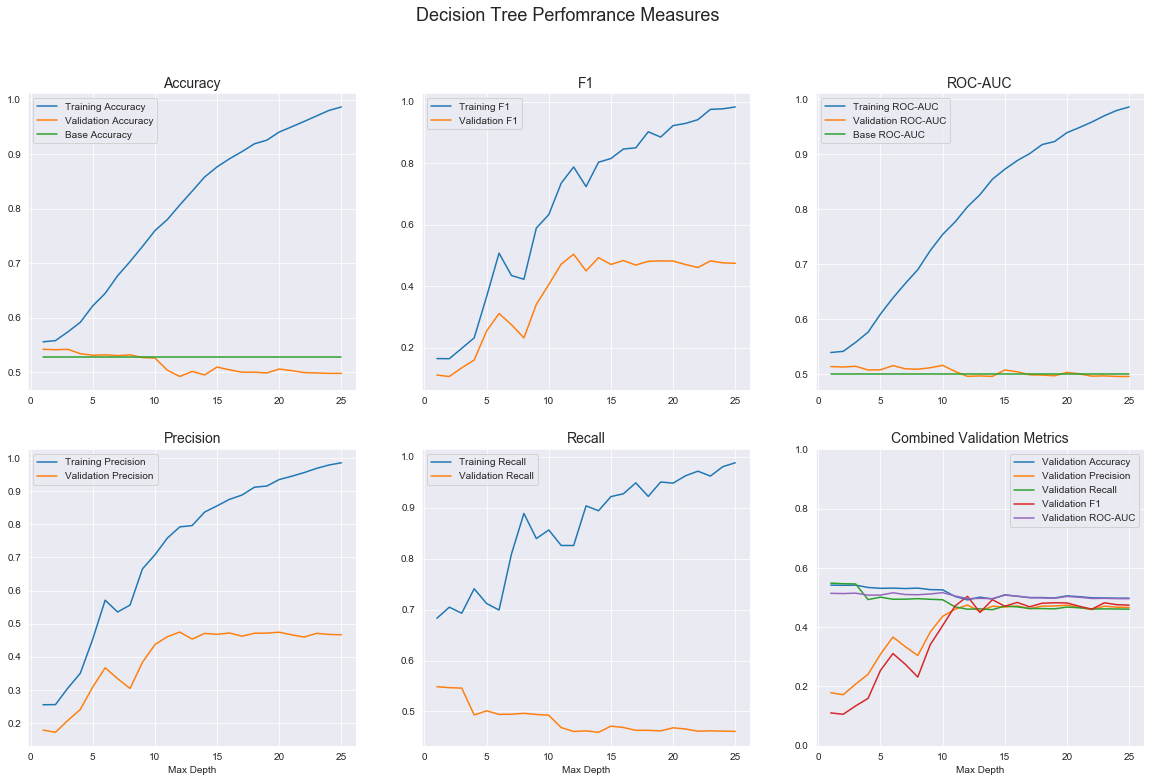

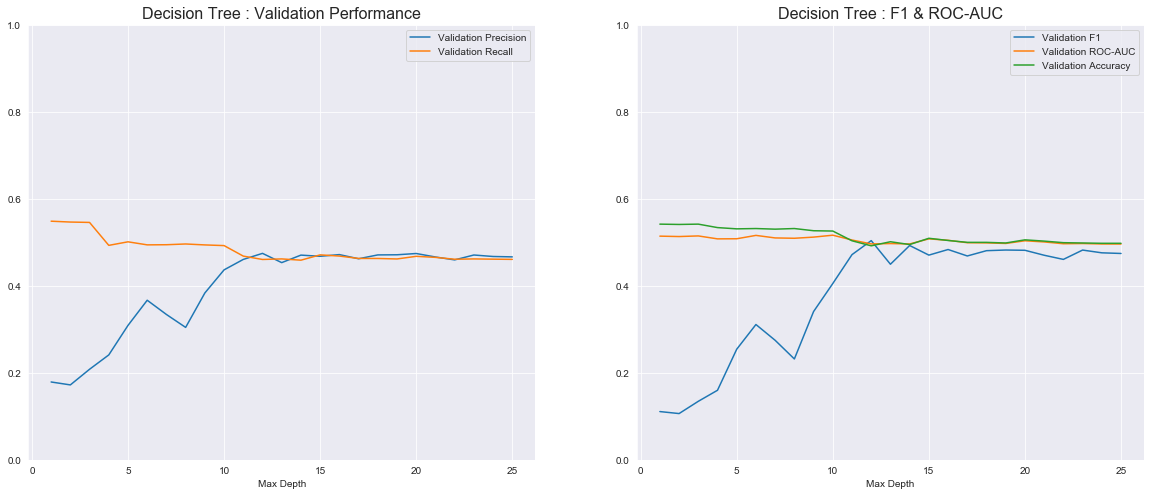

In [11]:
plot_results(df_tree_train, df_tree_valid, 'Decision Tree', 'Max Depth')

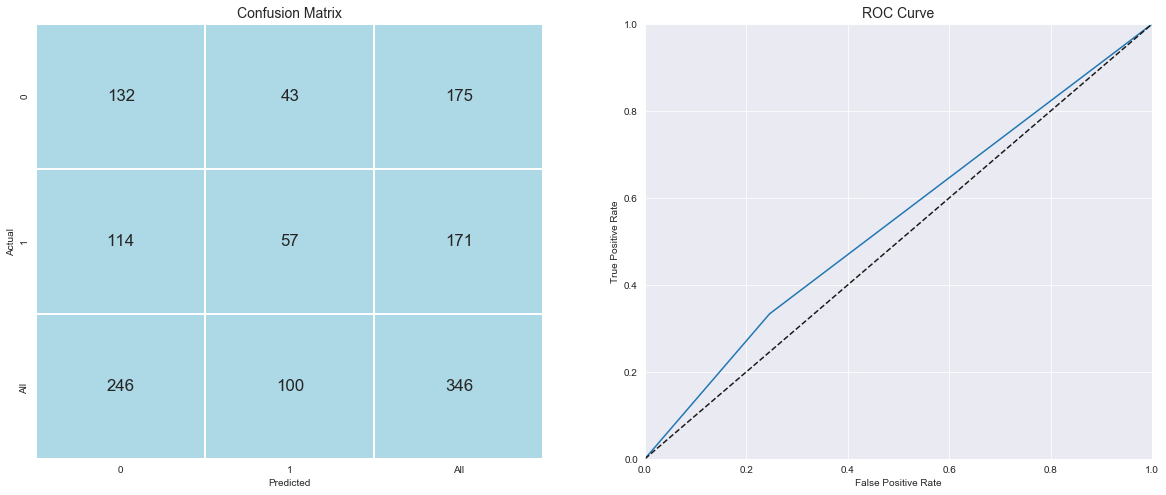

In [12]:
scores = get_final_results(df_tree_valid, 'decision tree', 'Validation ROC-AUC')

In [13]:
model_scores['Decision Tree'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree
Accuracy,0.527203,0.546243
F1,0.000000,0.420664
Precision,0.000000,0.570000
Recall,0.000000,0.333333
ROC-AUC,0.500000,0.543810


In [14]:
tree_clf = DecisionTreeClassifier(max_depth=df_tree_valid['Validation ROC-AUC'].argmax(), criterion='entropy', random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

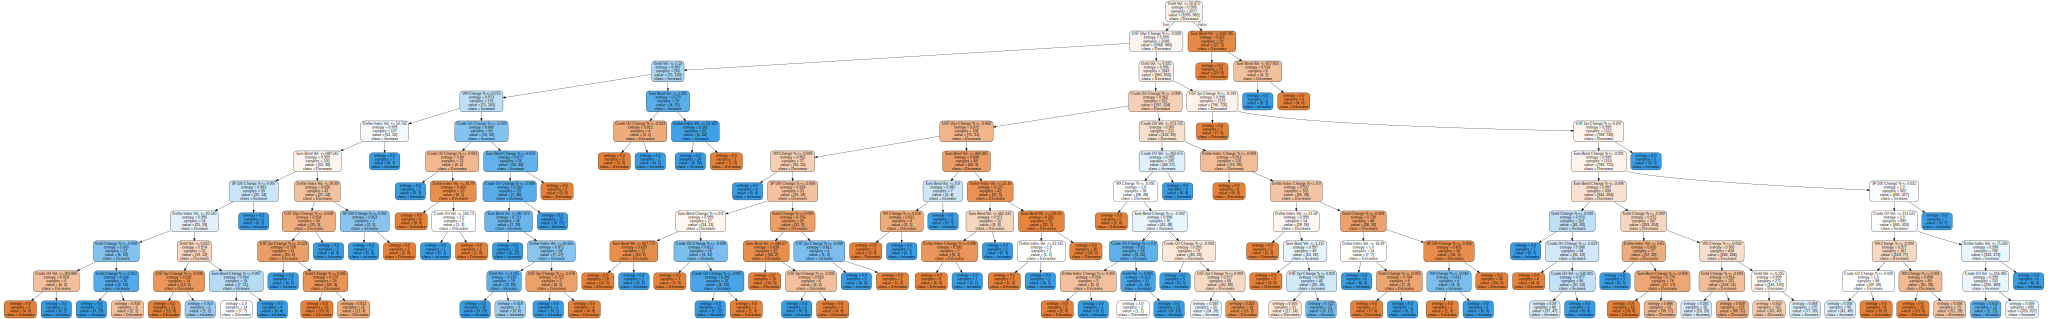

In [15]:
graph = Source(tree.export_graphviz(tree_clf, 
                                    out_file=None, 
                                    feature_names=df.columns[:-1], 
                                    class_names=['Decrease', 'Increase'], 
                                    rounded=True, 
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(cv_sets['x_4'][0])
for i in range(cv_splits):
    cv_sets['x_'+str(i)] = scaler.transform(cv_sets['x_'+str(i)][0]), scaler.transform(cv_sets['x_'+str(i)][1])
    cv_sets['y_'+str(i)] = cv_sets['y_'+str(i)][0].astype('float32'), cv_sets['y_'+str(i)][1].astype('float32')

In [17]:
cv_sets['x_4'][0].shape, cv_sets['y_4'][0].shape, cv_sets['x_4'][1].shape, cv_sets['y_4'][1].shape

((1731, 12), (1731,), (346, 12), (346,))

### Neural Network

In [18]:
X_train = cv_sets['x_3'][0]
y_train = cv_sets['y_3'][0]

X_valid = cv_sets['x_3'][1]
y_valid = cv_sets['y_3'][1]

X_train_valid = cv_sets['x_4'][0]
y_train_valid = cv_sets['y_4'][0]

X_test = cv_sets['x_4'][1]
y_test = cv_sets['y_4'][1]

In [19]:
X_train_valid.shape, y_train_valid.shape

((1731, 12), (1731,))

In [20]:
from keras.layers import SimpleRNN, Embedding, LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [21]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from keras import backend as K
import tensorflow as tf

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [22]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(12,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
np.random.seed(42)
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['accuracy', precision, recall, f1, auroc])

In [24]:
history = model.fit(X_train, 
                   y_train, 
                   epochs=50, 
                   batch_size=100, 
                   validation_data = (X_valid, y_valid))

Train on 1385 samples, validate on 346 samples
Epoch 1/50
1385/1385 [==============================] - 2s 2ms/step - loss: 0.7835 - acc: 0.5148 - precision: 0.4098 - recall: 0.0823 - f1: 0.1336 - auroc: 0.4775 - val_loss: 0.7704 - val_acc: 0.5520 - val_precision: 0.4197 - val_recall: 0.0641 - val_f1: 0.1068 - val_auroc: 0.5161
Epoch 2/50
1385/1385 [==============================] - 0s 39us/step - loss: 0.7523 - acc: 0.5162 - precision: 0.4596 - recall: 0.1640 - f1: 0.2393 - auroc: 0.4875 - val_loss: 0.7394 - val_acc: 0.5434 - val_precision: 0.3736 - val_recall: 0.0978 - val_f1: 0.1492 - val_auroc: 0.5246
Epoch 3/50
1385/1385 [==============================] - 0s 40us/step - loss: 0.7357 - acc: 0.5047 - precision: 0.4565 - recall: 0.2342 - f1: 0.3079 - auroc: 0.4891 - val_loss: 0.7201 - val_acc: 0.5405 - val_precision: 0.4258 - val_recall: 0.1480 - val_f1: 0.2107 - val_auroc: 0.5297
Epoch 4/50
1385/1385 [==============================] - 0s 40us/step - loss: 0.7243 - acc: 0.5083 - preci

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1', 'val_auroc', 'loss', 'acc', 'precision', 'recall', 'f1', 'auroc'])

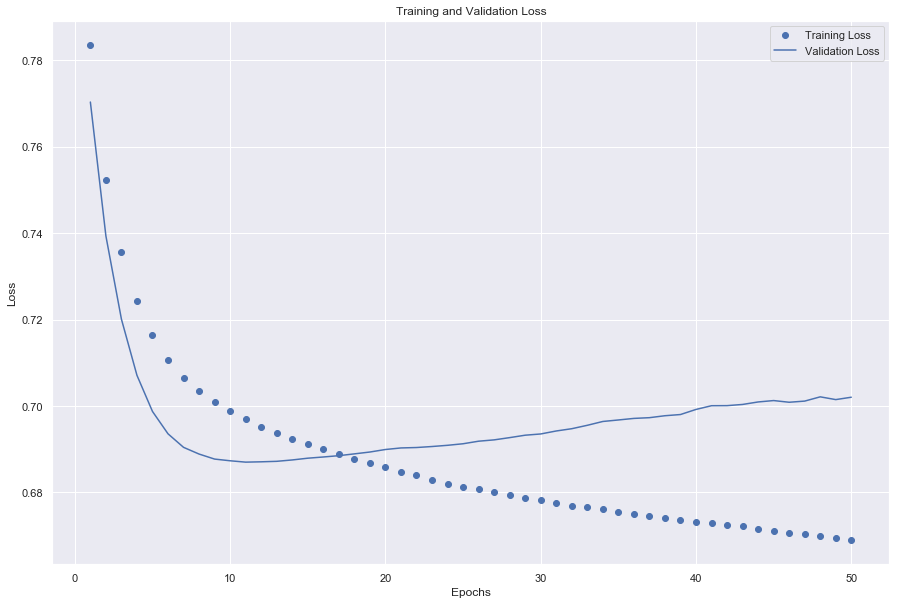

In [26]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
pd.DataFrame(history_dict).head()

,val_loss,val_acc,val_precision,val_recall,val_f1,val_auroc,loss,acc,precision,recall,f1,auroc
0,0.770357,0.552023,0.419717,0.064088,0.106812,0.516149,0.783462,0.514801,0.409833,0.082283,0.133619,0.477518
1,0.739358,0.543353,0.373555,0.097843,0.149156,0.524636,0.752293,0.516245,0.459622,0.164005,0.239315,0.487510
2,0.720101,0.540462,0.425843,0.147964,0.210666,0.529732,0.735729,0.504693,0.456469,0.234186,0.307864,0.489116
3,0.707108,0.540462,0.451089,0.200798,0.266653,0.533608,0.724284,0.508303,0.462658,0.301513,0.363001,0.496945
4,0.698746,0.560694,0.507686,0.272250,0.346640,0.541111,0.716436,0.509747,0.472623,0.356267,0.404551,0.500535


In [28]:
def nn_plot():
    #df_plot = pd.merge(df_boost_train[trn_cv_cols], df_boost_valid[val_cv_cols], left_index=True, right_index=True)
    df_plot = pd.DataFrame(history_dict)
    df_plot['Epochs'] = epochs
    df_plot.index = df_plot['Epochs']
    df_plot['Base Accuracy'] = base_accuracy
    df_plot['Base ROC-AUC'] = base_roc_auc

    y_acc = df_plot[['acc', 'val_acc', 'Base Accuracy']] #[['Training Accuracy', 'Validation Accuracy', 'Base Accuracy']]
    y_f1 = df_plot[['f1', 'val_f1']] #[['Training F1', 'Validation F1']]
    y_prec = df_plot[['precision', 'val_precision']] #[['Training Precision', 'Validation Precision']]
    y_rec = df_plot[['recall', 'val_recall']] #[['Training Recall', 'Validation Recall']]
    y_auc = df_plot[['auroc', 'val_auroc']] #[['Training ROC-AUC', 'Validation ROC-AUC', 'Base ROC-AUC']]

    fig, axs = plt.subplots(2, 3, figsize=(20,12))
    fig.suptitle('Neural Network Performance Measures', fontsize=18)
    axs[0,0].plot(y_acc)
    axs[0,0].set_title('Accuracy', fontsize=14)
    axs[0,0].legend((['Training Accuracy', 'Validation Accuracy', 'Base Accuracy']))
    axs[0,1].plot(y_f1)
    axs[0,1].set_title('F1', fontsize=14)
    axs[0,1].legend((['Training F1', 'Validation F1']))
    axs[1,0].plot(y_prec)
    axs[1,0].set_title('Precision', fontsize=14)
    axs[1,0].set_xlabel('Epochs')
    axs[1,0].legend(['Training Precision', 'Validation Precision'])
    axs[1,1].plot(y_rec)
    axs[1,1].set_title('Recall', fontsize=14)
    axs[1,1].set_xlabel('Epochs')
    axs[1,1].legend(['Training Recall', 'Validation Recall'])
    axs[0,2].plot(y_auc)
    axs[0,2].set_title('ROC-AUC', fontsize=14)
    axs[0,2].legend(['Training ROC-AUC', 'Validation ROC-AUC', 'Base ROC-AUC'])
    axs[1,2].plot(df_plot[['val_acc', 'val_precision', 'val_recall', 'val_f1', 'val_auroc']])
    axs[1,2].set_title('Combined Validation Metrics', fontsize=14)
    axs[1,2].set_xlabel('Epochs')
    axs[1,2].legend(val_cv_cols)
    axs[1,2].set_ylim(0,1);

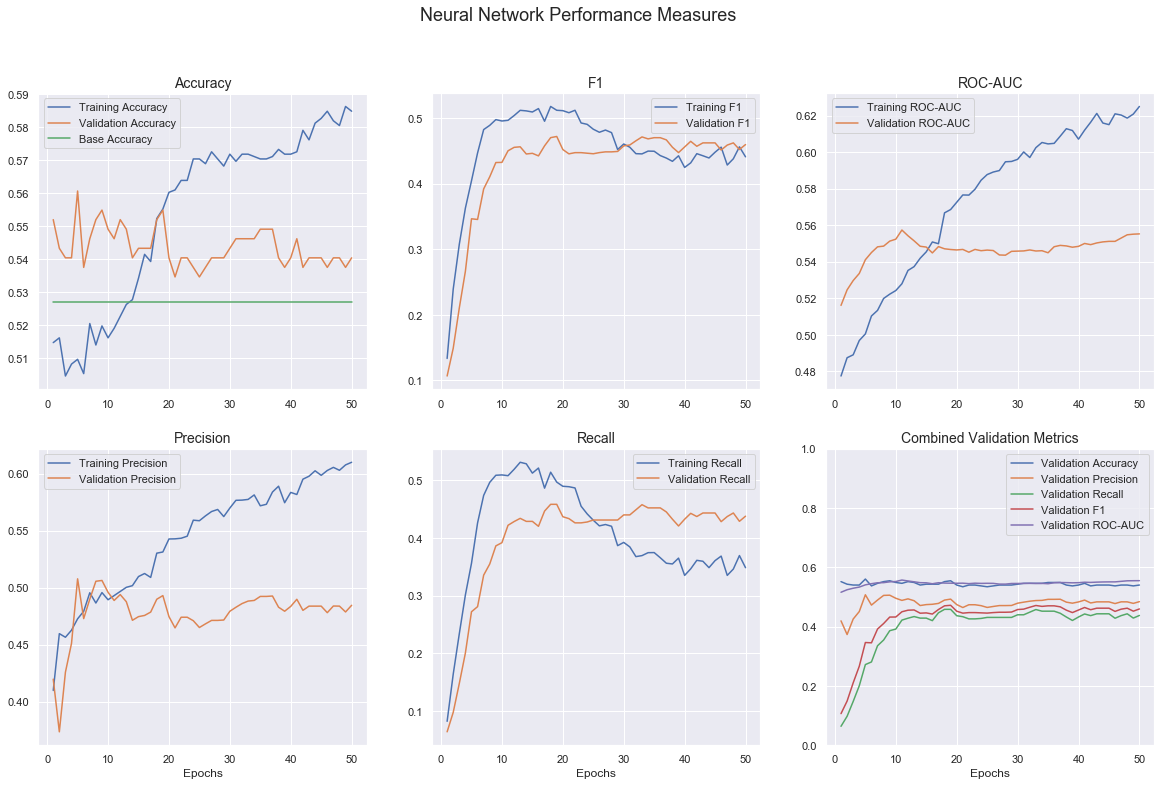

In [29]:
nn_plot()

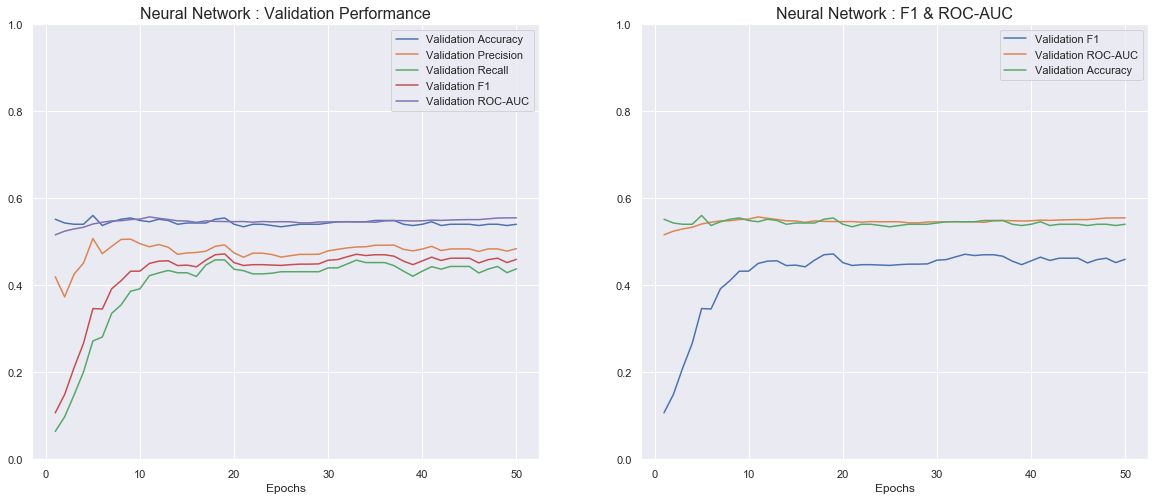

In [30]:
df_plot = pd.DataFrame(history_dict)
df_plot['Epochs'] = epochs
df_plot.index = df_plot['Epochs']
df_plot['Base Accuracy'] = base_accuracy
df_plot['Base ROC-AUC'] = base_roc_auc

fig, axs = plt.subplots(1, 2, figsize=(20,8))

axs[0].plot(df_plot[['val_acc', 'val_precision', 'val_recall', 'val_f1', 'val_auroc']])
axs[0].set_xlabel('Epochs')
axs[0].set_title('Neural Network : Validation Performance', fontsize=16)
axs[0].legend(val_cv_cols)
axs[0].set_ylim(0,1)
axs[1].plot(df_plot[['val_f1', 'val_auroc', 'val_acc']])
axs[1].set_title('Neural Network : F1 & ROC-AUC', fontsize=16)
axs[1].set_xlabel('Epochs')
axs[1].legend(['Validation F1', 'Validation ROC-AUC', 'Validation Accuracy'])
plt.ylim(0,1);

In [31]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(12,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

np.random.seed(42)
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['accuracy', precision, recall, f1, auroc])

model.fit(X_train_valid, y_train_valid, epochs=df_plot['val_auroc'].argmax(), batch_size=100)
results = model.evaluate(X_test, y_test)

Epoch 1/11
1731/1731 [==============================] - 0s 128us/step - loss: 0.6953 - acc: 0.5118 - precision: 0.4832 - recall: 0.5085 - f1: 0.4911 - auroc: 0.5270
Epoch 2/11
1731/1731 [==============================] - 0s 30us/step - loss: 0.6922 - acc: 0.5205 - precision: 0.4898 - recall: 0.4330 - f1: 0.4560 - auroc: 0.5286
Epoch 3/11
1731/1731 [==============================] - 0s 29us/step - loss: 0.6909 - acc: 0.5274 - precision: 0.4920 - recall: 0.3747 - f1: 0.4234 - auroc: 0.5330
Epoch 4/11
1731/1731 [==============================] - 0s 30us/step - loss: 0.6900 - acc: 0.5298 - precision: 0.4982 - recall: 0.3428 - f1: 0.4029 - auroc: 0.5379
Epoch 5/11
1731/1731 [==============================] - 0s 30us/step - loss: 0.6894 - acc: 0.5350 - precision: 0.5114 - recall: 0.3289 - f1: 0.3953 - auroc: 0.5380
Epoch 6/11
1731/1731 [==============================] - 0s 32us/step - loss: 0.6888 - acc: 0.5378 - precision: 0.5075 - recall: 0.3019 - f1: 0.3772 - auroc: 0.5395
Epoch 7/11
1731

In [32]:
model_scores['Dense Neural Network'] = results[1:]
model_scores

,Base Case,Decision Tree,Dense Neural Network
Accuracy,0.527203,0.546243,0.549133
F1,0.000000,0.420664,0.568108
Precision,0.000000,0.570000,0.343115
Recall,0.000000,0.333333,0.409327
ROC-AUC,0.500000,0.543810,0.523614


In [33]:
y_pred = model.predict(X_test)
model_predictions = np.asarray([round(num[0],0) for num in y_pred])

cm_df = pd.crosstab(y_test, model_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
roc = roc_curve(y_test, model_predictions)

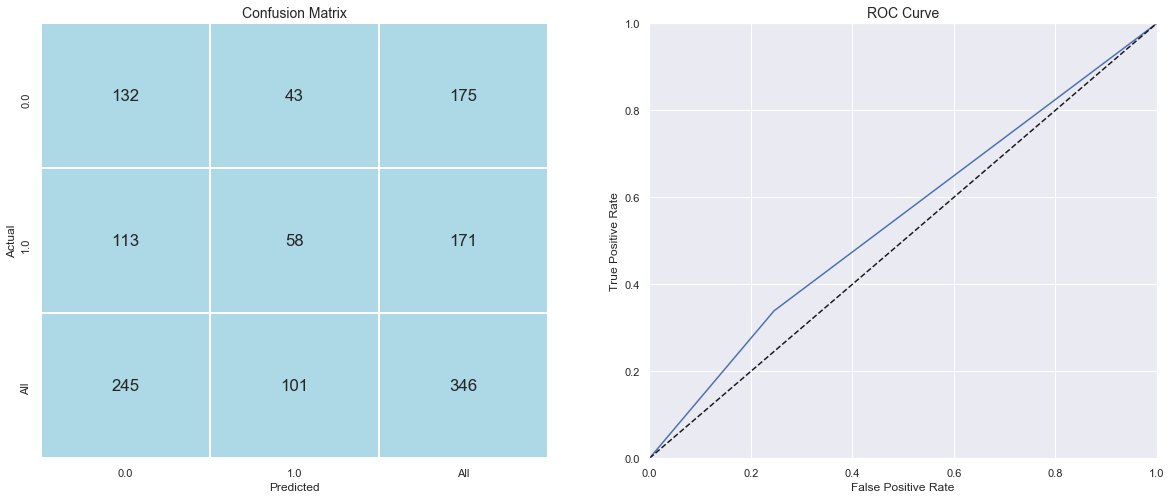

In [34]:
fpr, tpr, thresholds = roc[0], roc[1], roc[2]

from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 2, figsize=(20,8))
sns.set(font_scale=1.4)
sns.heatmap(cm_df, annot=True, fmt='g', cmap=ListedColormap(['lightblue']), cbar=False, linewidths=1, ax=axs[0]);
sns.set(font_scale=1)
axs[0].set_title('Confusion Matrix', fontsize=14)
axs[1].plot(fpr, tpr)
axs[1].plot([0,1], [0,1], 'k--')
axs[1].axis([0,1,0,1])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve', fontsize=14);

In [35]:
#from keras.layers import SimpleRNN, Embedding, LSTM, Dense
#from keras.models import Sequential

In [36]:

#model = Sequential()
#model.add(Embedding(1, 12))
#model.add(LSTM(12))
#model.add(Dense(1, activation='sigmoid'))

In [37]:
#np.random.seed(42)
#model.compile(optimizer='rmsprop', 
#             loss='binary_crossentropy', 
#             metrics=['acc'])

In [38]:
#history = model.fit(X_train, y_train, 
#                   epochs=25, batch_size=100, 
#                   validation_data=(X_valid, y_valid))

In [39]:
#loss_values = history.history['loss']#
#val_loss_values = history.history['val_loss']

#epochs = range(1, len(loss_values) + 1)

#plt.figure(figsize=(15,10))
#plt.plot(epochs, loss_values, 'bo', label='Training Loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
#plt.title('Training and Validation Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()

#plt.show()

In [40]:
#plt.clf()
#acc = history.history['acc']
#val_acc = history.history['val_acc']

#epochs = range(1, len(acc) + 1)

#plt.figure(figsize=(15,10))
#plt.plot(epochs, acc, 'bo', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
#plt.plot(epochs, [base_case] * len(epochs), label='Base Case')
#plt.title('Training and Validation Accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()

In [41]:
#model = Sequential()
#model.add(Embedding(1, 12))
#model.add(LSTM(12))
#model.add(Dense(1, activation='sigmoid'))

#np.random.seed(42)
#model.compile(optimizer='rmsprop', 
#             loss='binary_crossentropy', 
#             metrics=['acc'])

#model.fit(X_train_valid, y_train_valid, epochs=13, batch_size=100)
#results = model.evaluate(X_test, y_test)

In [42]:
#train_score = acc[9]
#valid_score = val_acc[9]
#test_score = results[1]
#model_accuracy['Recurrent Neural Net'] = [train_score, valid_score, test_score]
#model_accuracy

### Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
df_boost_train, df_boost_valid = setup_df(range(1,151), 'boosting')

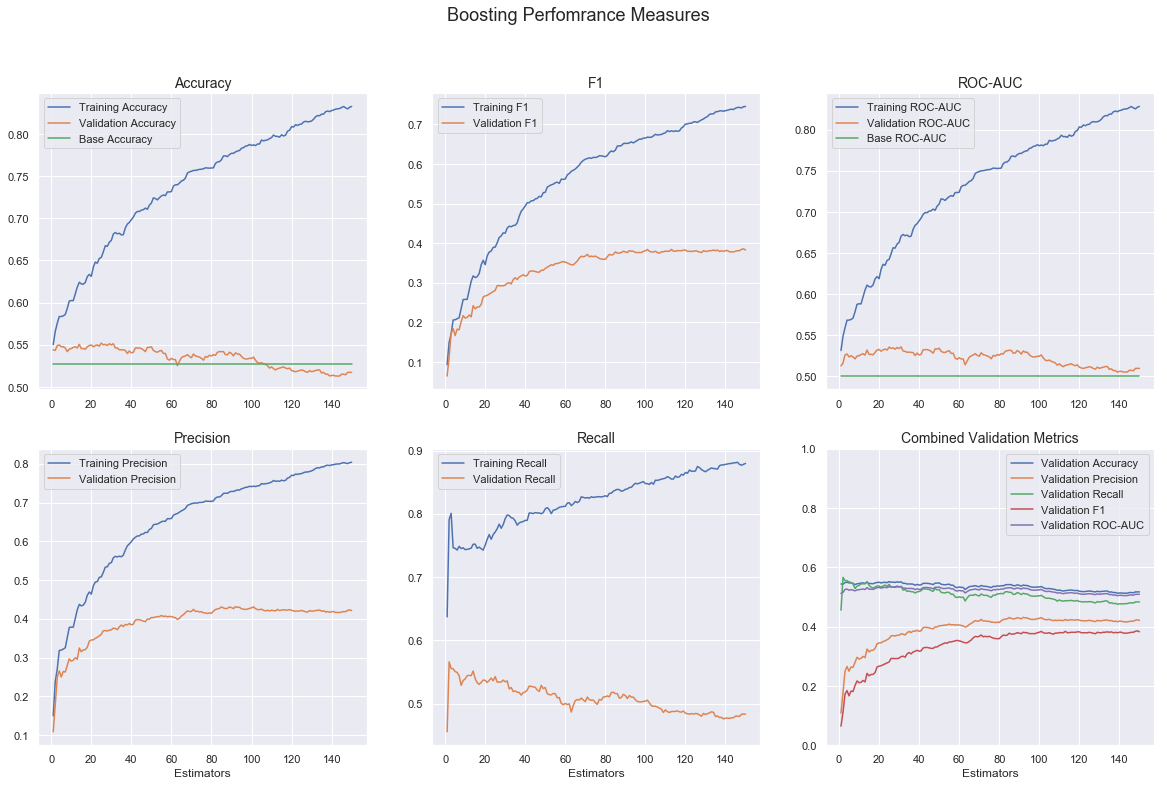

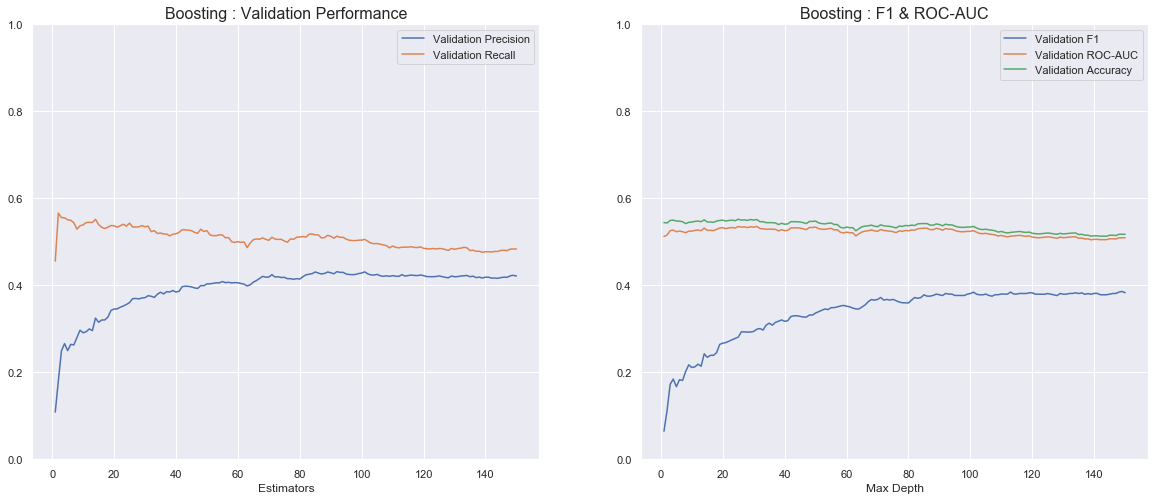

In [45]:
plot_results(df_boost_train, df_boost_valid, 'Boosting', 'Estimators')

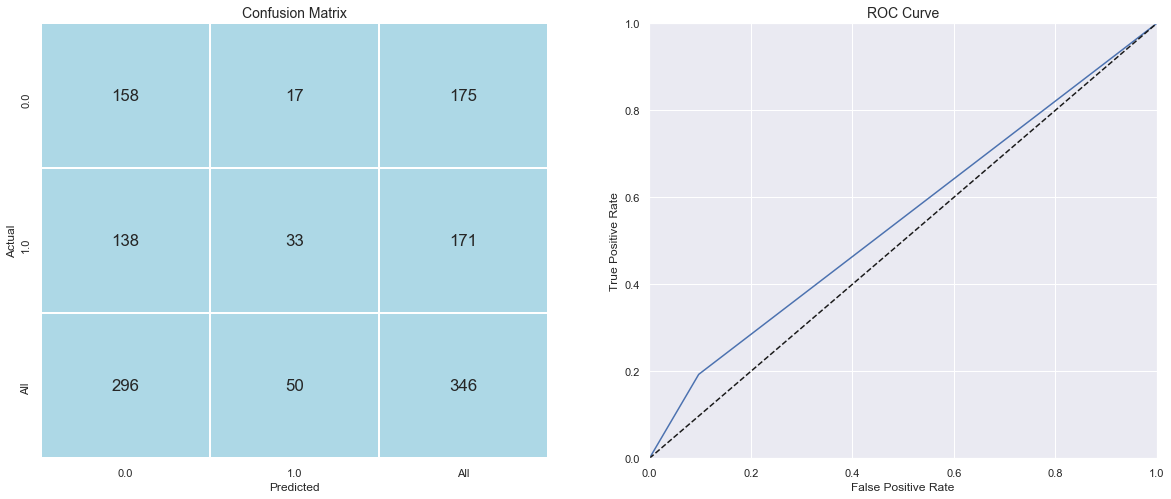

In [46]:
scores = get_final_results(df_boost_valid, 'boosting', 'Validation ROC-AUC')

In [47]:
model_scores['Boosting'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting
Accuracy,0.527203,0.546243,0.549133,0.552023
F1,0.000000,0.420664,0.568108,0.298643
Precision,0.000000,0.570000,0.343115,0.660000
Recall,0.000000,0.333333,0.409327,0.192982
ROC-AUC,0.500000,0.543810,0.523614,0.547920


### SVM

In [48]:
from sklearn.svm import LinearSVC, SVC

In [49]:
df_svm_train, df_svm_valid = setup_df(range(1,150), 'linear svm')

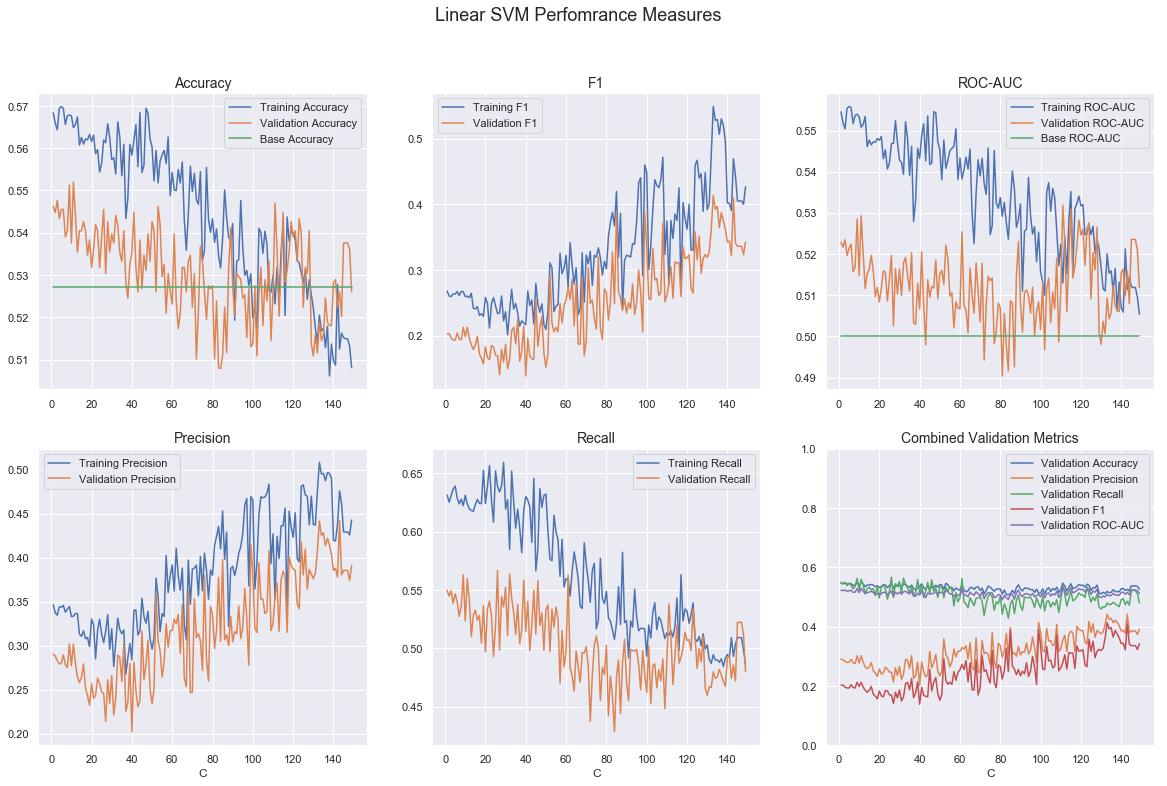

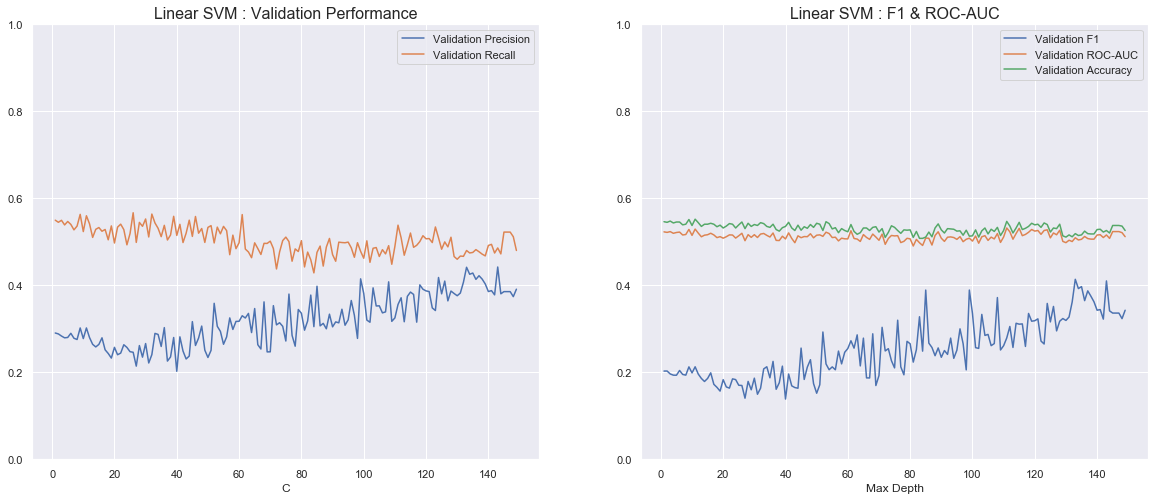

In [50]:
plot_results(df_svm_train, df_svm_valid, 'Linear SVM', 'C')

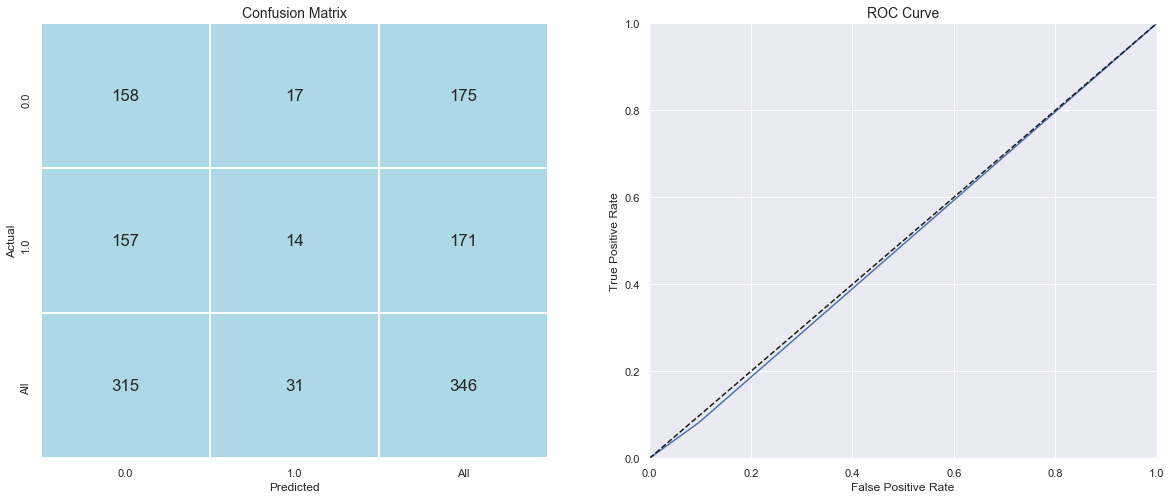

In [51]:
scores = get_final_results(df_tree_valid, 'linear svm', 'Validation ROC-AUC')

In [52]:
model_scores['Linear SVM'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM
Accuracy,0.527203,0.546243,0.549133,0.552023,0.497110
F1,0.000000,0.420664,0.568108,0.298643,0.138614
Precision,0.000000,0.570000,0.343115,0.660000,0.451613
Recall,0.000000,0.333333,0.409327,0.192982,0.081871
ROC-AUC,0.500000,0.543810,0.523614,0.547920,0.492364


In [53]:
df_svm_train, df_svm_valid = setup_df(range(1,26), 'kernel svm')

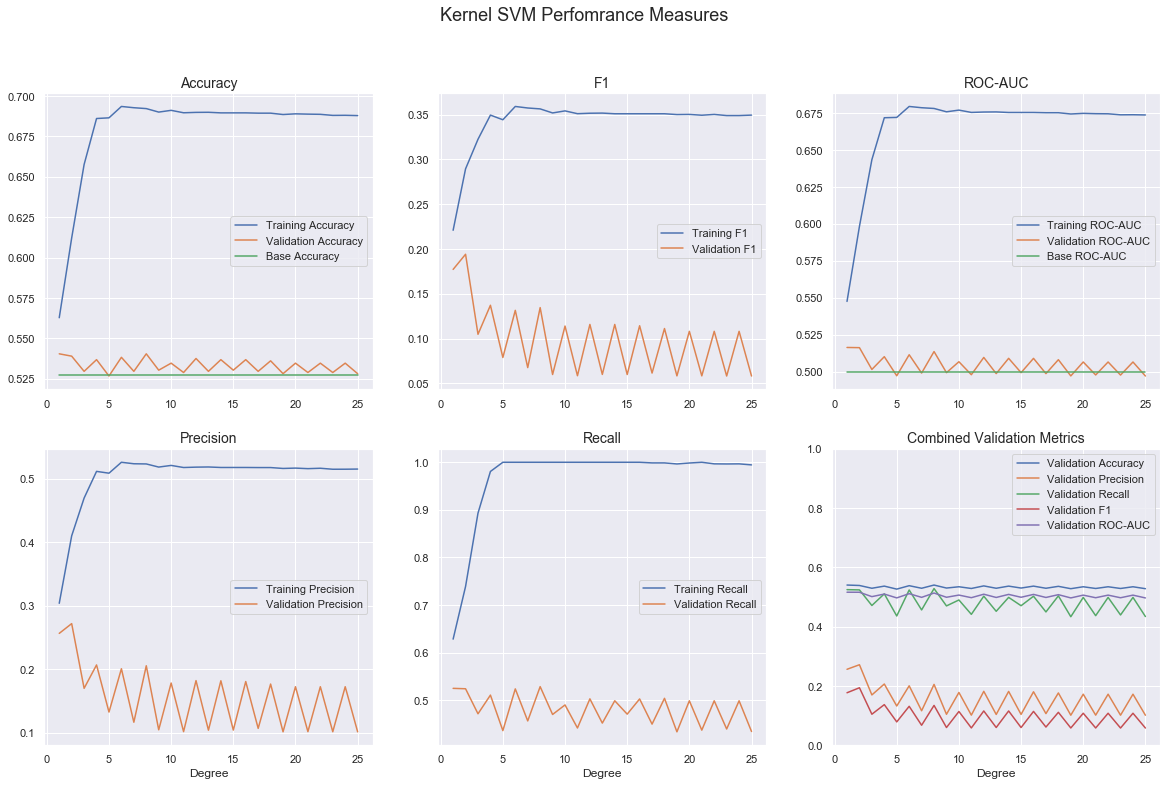

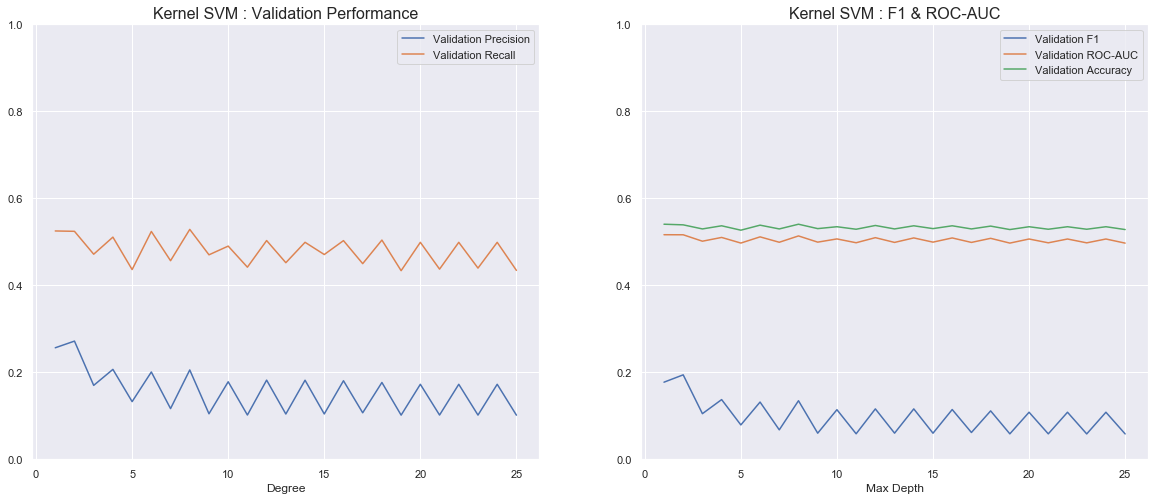

In [54]:
plot_results(df_svm_train, df_svm_valid, 'Kernel SVM', 'Degree')

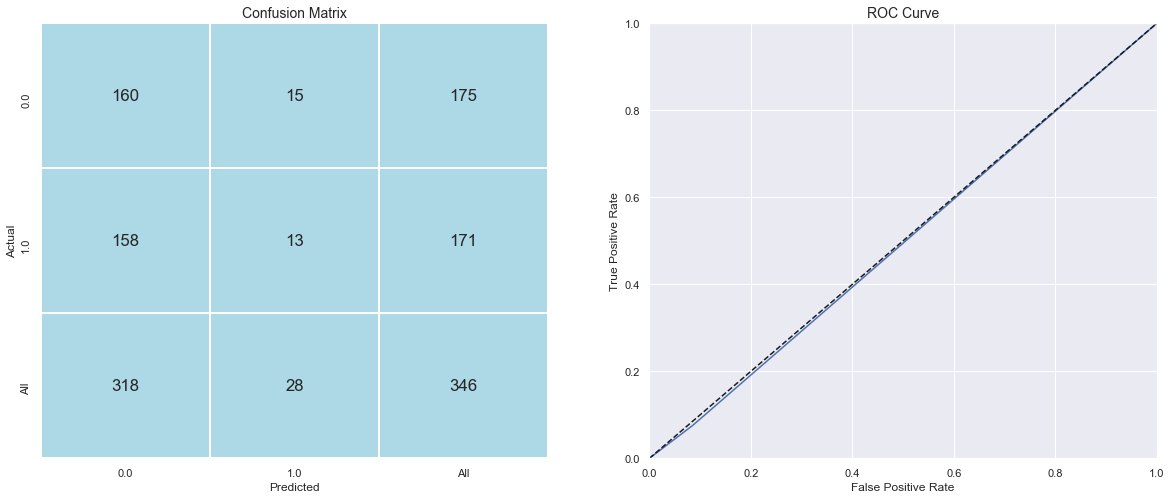

In [55]:
scores = get_final_results(df_svm_valid, 'kernel svm', 'Validation ROC-AUC')

In [56]:
model_scores['Kernel SVM'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM
Accuracy,0.527203,0.546243,0.549133,0.552023,0.497110,0.500000
F1,0.000000,0.420664,0.568108,0.298643,0.138614,0.130653
Precision,0.000000,0.570000,0.343115,0.660000,0.451613,0.464286
Recall,0.000000,0.333333,0.409327,0.192982,0.081871,0.076023
ROC-AUC,0.500000,0.543810,0.523614,0.547920,0.492364,0.495155


### KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
df_knn_train, df_knn_valid = setup_df(range(1, 50), 'knn')

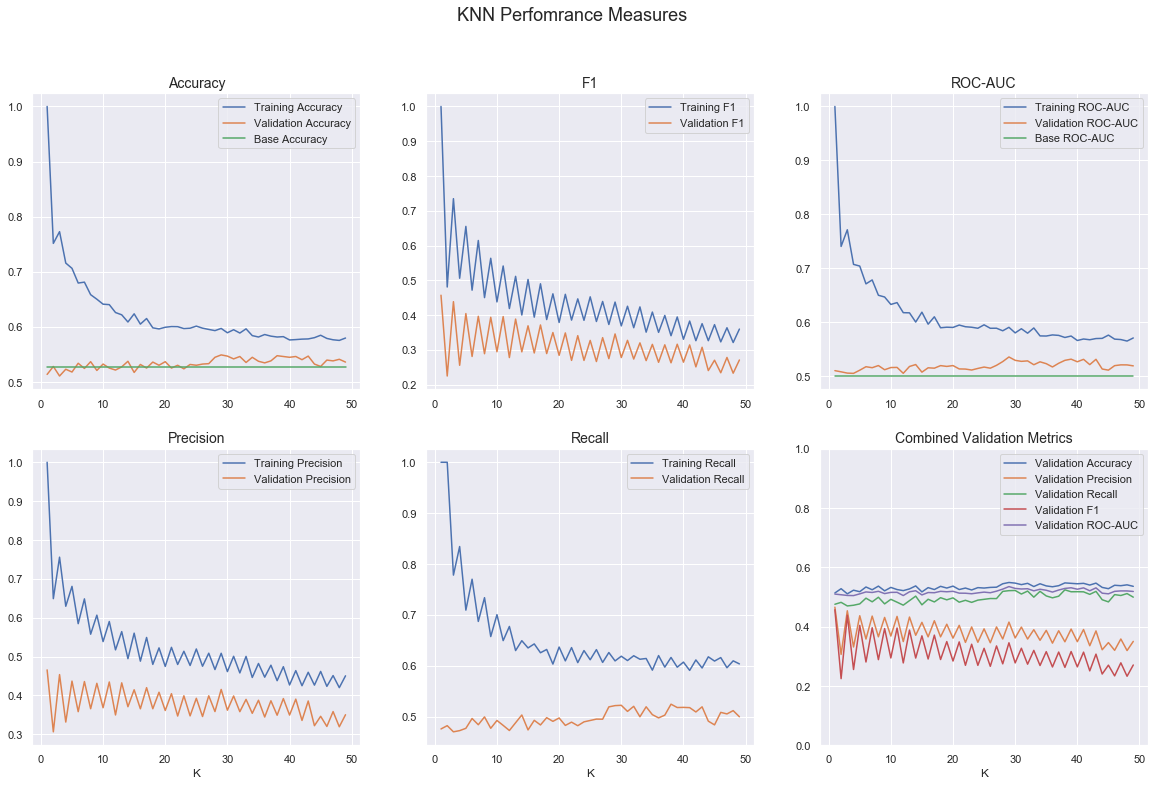

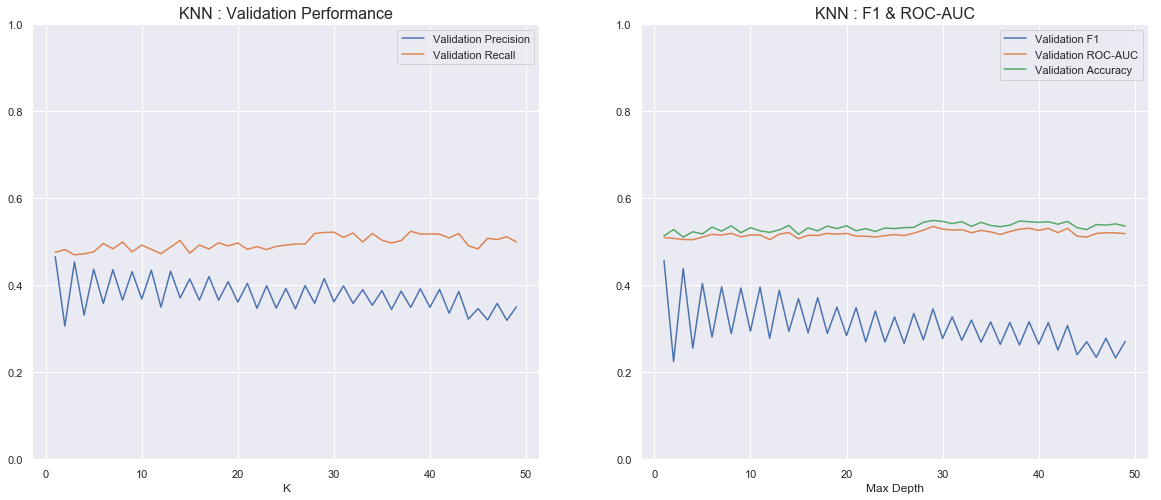

In [59]:
plot_results(df_knn_train, df_knn_valid, 'KNN', 'K')

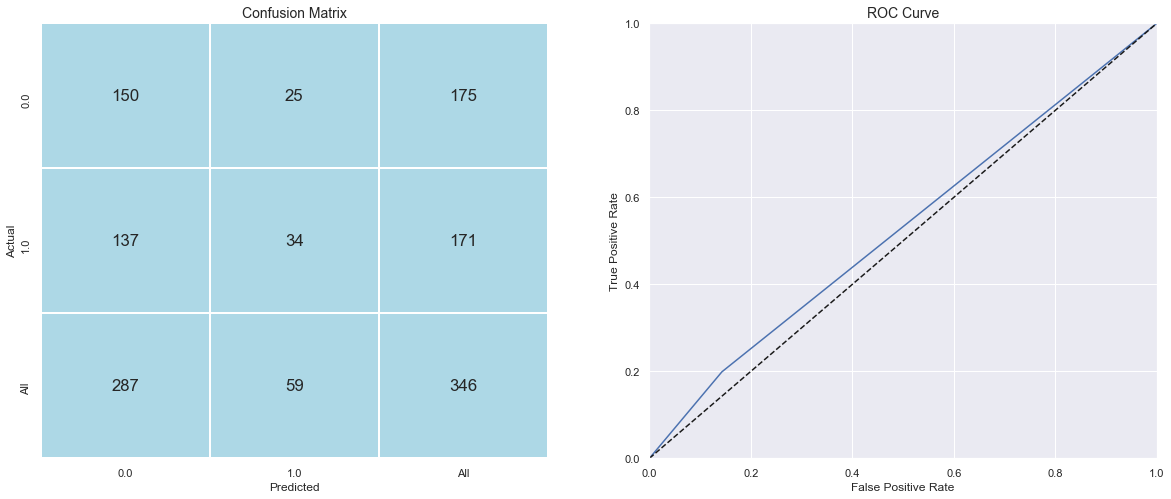

In [60]:
scores = get_final_results(df_knn_valid, 'knn', 'Validation ROC-AUC')

In [61]:
model_scores['KNN'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.527203,0.546243,0.549133,0.552023,0.497110,0.500000,0.531792
F1,0.000000,0.420664,0.568108,0.298643,0.138614,0.130653,0.295652
Precision,0.000000,0.570000,0.343115,0.660000,0.451613,0.464286,0.576271
Recall,0.000000,0.333333,0.409327,0.192982,0.081871,0.076023,0.198830
ROC-AUC,0.500000,0.543810,0.523614,0.547920,0.492364,0.495155,0.527987


### Final Summary

In [62]:
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.527203,0.546243,0.549133,0.552023,0.497110,0.500000,0.531792
F1,0.000000,0.420664,0.568108,0.298643,0.138614,0.130653,0.295652
Precision,0.000000,0.570000,0.343115,0.660000,0.451613,0.464286,0.576271
Recall,0.000000,0.333333,0.409327,0.192982,0.081871,0.076023,0.198830
ROC-AUC,0.500000,0.543810,0.523614,0.547920,0.492364,0.495155,0.527987


In [63]:
accuracy_summary= model_scores.T.sort_values(by=['ROC-AUC'], ascending=False)
accuracy_summary

,Accuracy,F1,Precision,Recall,ROC-AUC
Boosting,0.552023,0.298643,0.660000,0.192982,0.547920
Decision Tree,0.546243,0.420664,0.570000,0.333333,0.543810
KNN,0.531792,0.295652,0.576271,0.198830,0.527987
Dense Neural Network,0.549133,0.568108,0.343115,0.409327,0.523614
Base Case,0.527203,0.000000,0.000000,0.000000,0.500000
Kernel SVM,0.500000,0.130653,0.464286,0.076023,0.495155
Linear SVM,0.497110,0.138614,0.451613,0.081871,0.492364


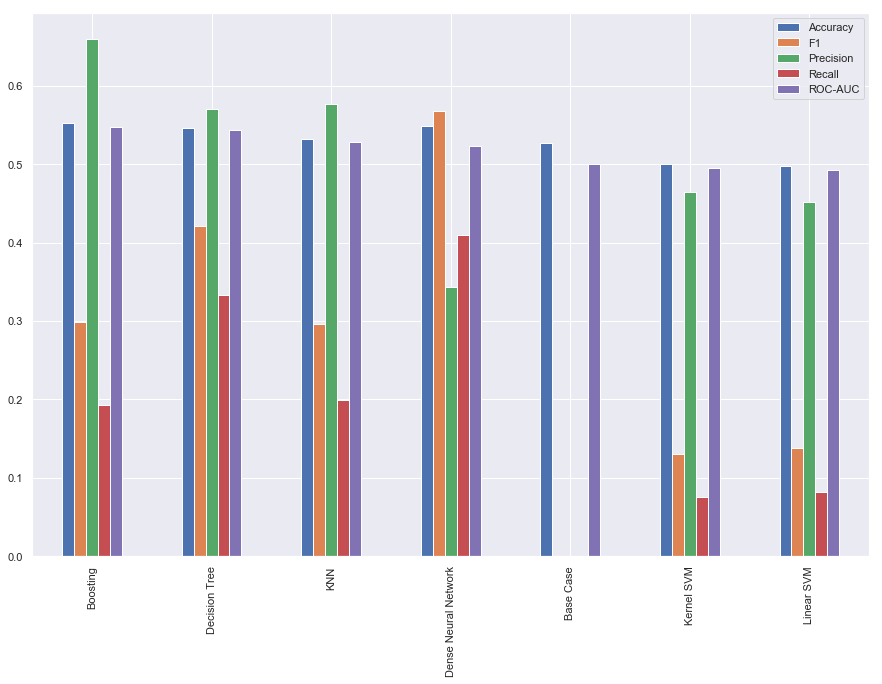

In [64]:
accuracy_summary.plot.bar(figsize=(15,10));